In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Load the dataset
df = pd.read_csv("/content/GlobalWeatherRepository.csv")

In [ ]:
df

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.5200,69.1800,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.400,26.600,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.3300,19.8200,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.100,2.000,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.7600,3.0500,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.400,18.400,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.5000,1.5200,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.700,0.900,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.8400,13.2300,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.400,262.300,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57680,Venezuela,Caracas,10.5000,-66.9167,America/Caracas,1741513500,2025-03-09 05:45,24.2,75.6,Clear,...,12.765,17.205,1,2,06:38 AM,06:38 PM,03:01 PM,03:16 AM,Waxing Gibbous,76
57681,Vietnam,Hanoi,21.0333,105.8500,Asia/Bangkok,1741513500,2025-03-09 16:45,21.4,70.5,Mist,...,146.890,147.815,4,10,06:10 AM,06:04 PM,01:39 PM,02:43 AM,Waxing Gibbous,71
57682,Yemen,Sanaa,15.3547,44.2067,Asia/Aden,1741513500,2025-03-09 12:45,23.5,74.3,Sunny,...,32.005,99.345,2,3,06:15 AM,06:12 PM,02:09 PM,02:45 AM,Waxing Gibbous,73
57683,Zambia,Lusaka,-15.4167,28.2833,Africa/Lusaka,1741513500,2025-03-09 11:45,22.4,72.4,Patchy rain nearby,...,5.365,5.550,1,1,06:09 AM,06:25 PM,03:19 PM,01:44 AM,Waxing Gibbous,73


In [ ]:
# Convert last_updated to datetime
if 'last_updated' in df.columns:
    df['last_updated'] = pd.to_datetime(df['last_updated'], errors='coerce')
    df = df.sort_values(by='last_updated')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57685 entries, 186 to 57613
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   country                       57685 non-null  object        
 1   location_name                 57685 non-null  object        
 2   latitude                      57685 non-null  float64       
 3   longitude                     57685 non-null  float64       
 4   timezone                      57685 non-null  object        
 5   last_updated_epoch            57685 non-null  int64         
 6   last_updated                  57685 non-null  datetime64[ns]
 7   temperature_celsius           57685 non-null  float64       
 8   temperature_fahrenheit        57685 non-null  float64       
 9   condition_text                57685 non-null  object        
 10  wind_mph                      57685 non-null  float64       
 11  wind_kph                      5

In [ ]:
# Normalize numerical columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [ ]:
# Detect and Remove Outliers using IQR Method
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

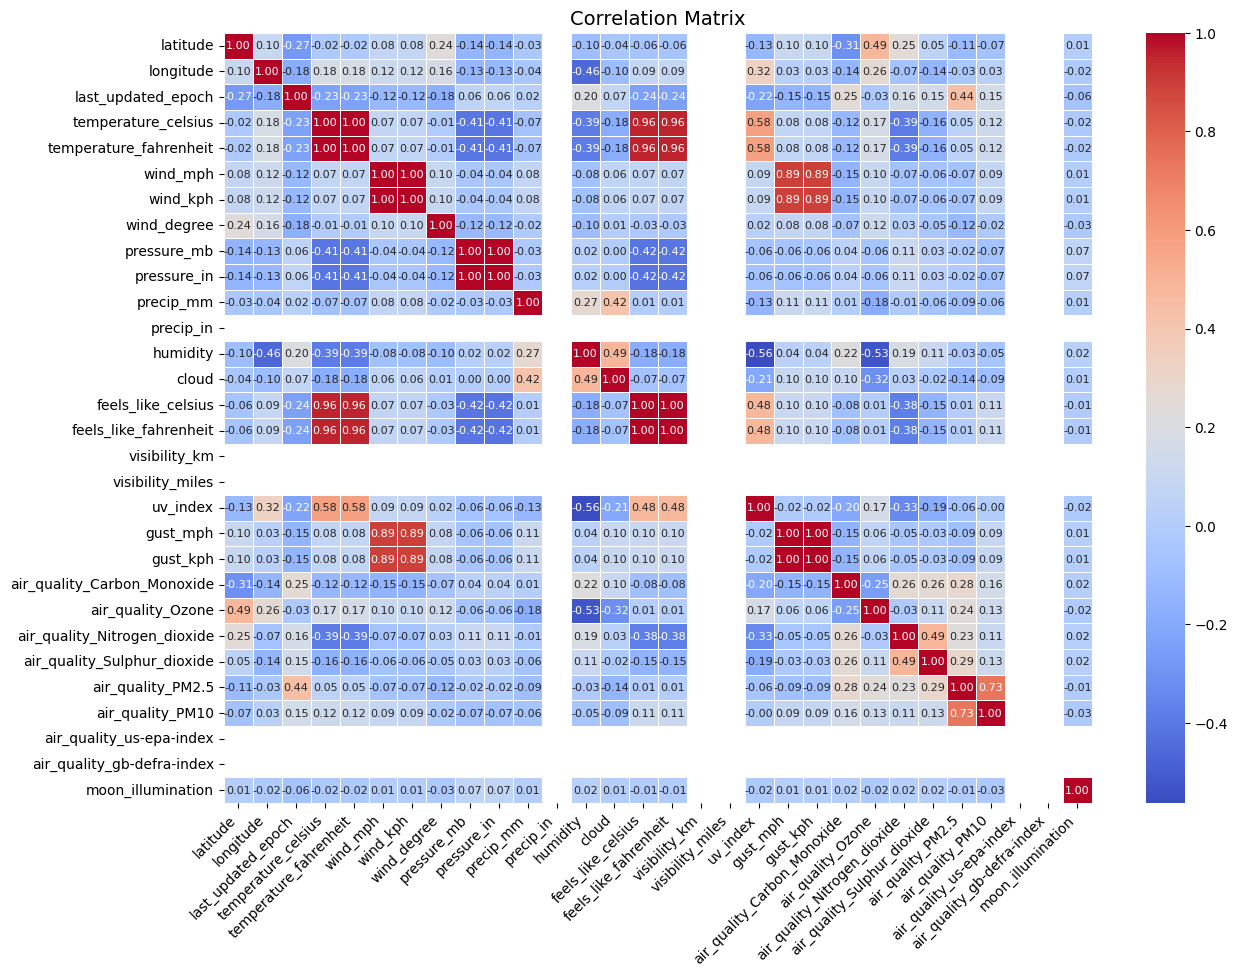

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 8})
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Correlation Matrix", fontsize=14)
plt.show()

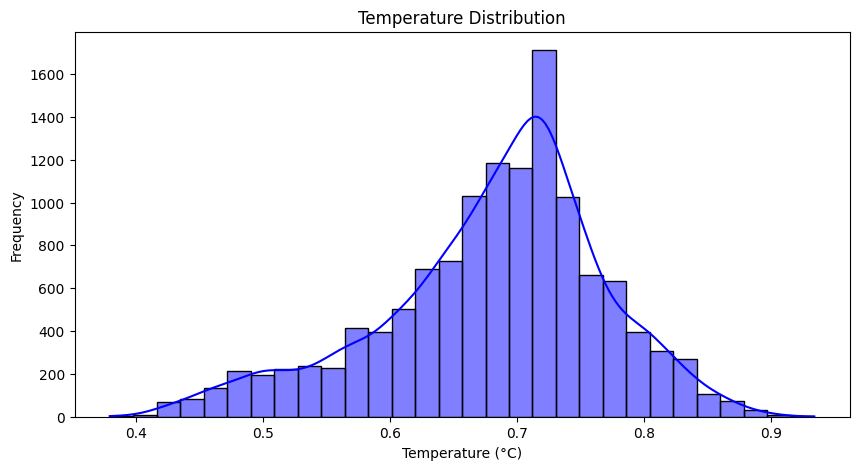

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['temperature_celsius'], bins=30, kde=True, color='blue')
plt.title("Temperature Distribution")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

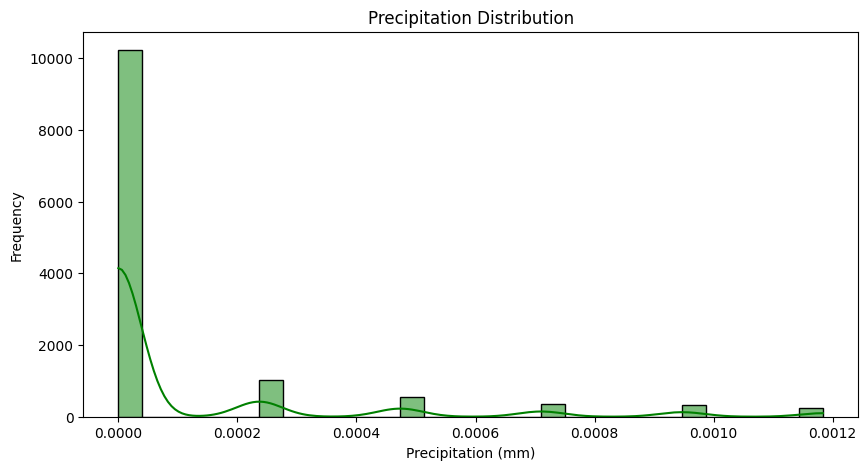

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['precip_mm'], bins=30, kde=True, color='green')
plt.title("Precipitation Distribution")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()

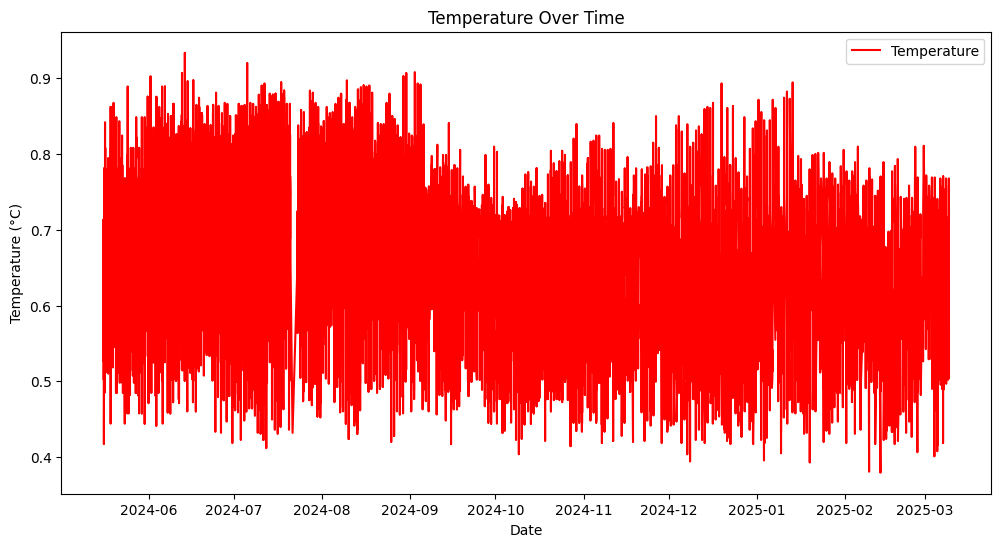

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['last_updated'], df['temperature_celsius'], label='Temperature', color='red')
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Over Time")
plt.legend()
plt.show()

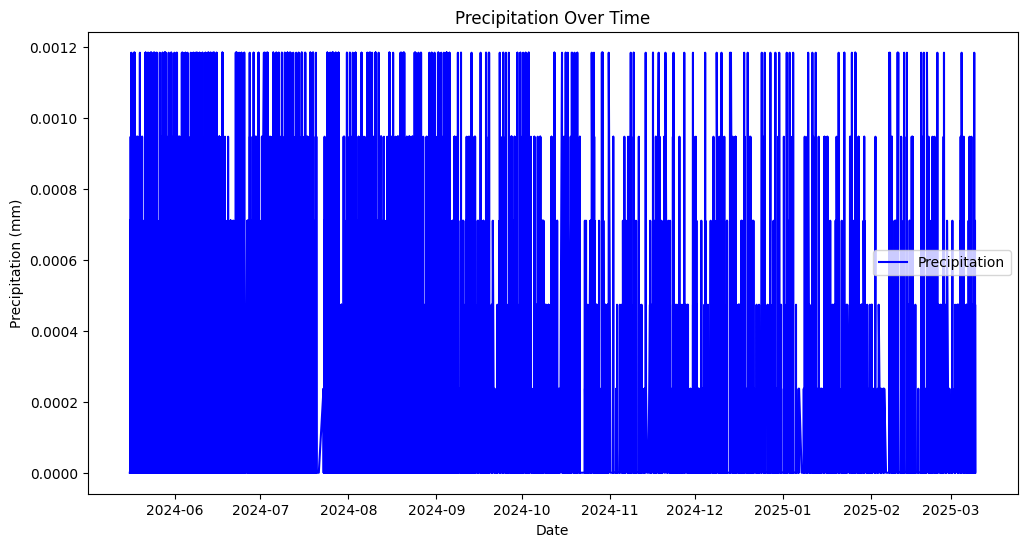

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['last_updated'], df['precip_mm'], label='Precipitation', color='blue')
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.title("Precipitation Over Time")
plt.legend()
plt.show()

In [ ]:
df

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
17,Belize,Belmopan,0.555239,0.243863,America/Belize,0.000000,2024-05-16 02:45:00,0.686910,0.687406,Overcast,...,0.004656,0.238446,0.0,0.0,05:23 AM,06:20 PM,12:56 PM,01:04 AM,Waxing Gibbous,0.55
136,Paraguay,Pasto,0.207207,0.321793,America/La_Paz,0.000000,2024-05-16 04:45:00,0.526316,0.526237,Clear,...,0.002116,0.234857,0.0,0.0,06:25 AM,05:37 PM,01:31 PM,12:34 AM,Waxing Gibbous,0.55
72,Haiti,Port-Au-Prince,0.567473,0.290221,America/Port-au-Prince,0.000000,2024-05-16 04:45:00,0.619433,0.619190,Clear,...,0.006515,0.237000,0.0,0.0,06:15 AM,07:17 PM,01:47 PM,01:58 AM,Waxing Gibbous,0.55
133,Bolivia,National,0.285633,0.305062,America/La_Paz,0.000000,2024-05-16 04:45:00,0.570850,0.571214,Clear,...,0.001001,0.234629,0.0,0.0,06:37 AM,06:12 PM,01:49 PM,01:07 AM,Waxing Gibbous,0.55
5,Antigua and Barbuda,Saint John's,0.554007,0.319818,America/Antigua,0.000000,2024-05-16 04:45:00,0.686910,0.686657,Partly cloudy,...,0.000629,0.234946,0.0,0.0,05:36 AM,06:32 PM,01:05 PM,01:14 AM,Waxing Gibbous,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57683,Zambia,Lusaka,0.245456,0.574130,Africa/Lusaka,1.000000,2025-03-09 11:45:00,0.638327,0.638681,Patchy rain nearby,...,0.003210,0.235079,0.0,0.0,06:09 AM,06:25 PM,03:19 PM,01:44 AM,Waxing Gibbous,0.73
57518,Madagascar,Ivory,0.160581,0.625388,Indian/Antananarivo,0.999965,2025-03-09 12:30:00,0.767881,0.768366,Sunny,...,0.002866,0.235196,0.0,0.0,05:53 AM,06:16 PM,03:24 PM,01:06 AM,Waxing Gibbous,0.73
57591,Madagascar,Antananarivo,0.212265,0.628398,Indian/Antananarivo,1.000000,2025-03-09 12:45:00,0.635628,0.635682,Light rain,...,0.000573,0.234516,0.0,0.0,05:51 AM,06:10 PM,03:07 PM,01:16 AM,Waxing Gibbous,0.73
57599,Mauritius,Port Louis,0.200456,0.656563,Indian/Mauritius,1.000000,2025-03-09 13:45:00,0.758435,0.757871,Overcast,...,0.006648,0.236486,0.0,0.0,06:10 AM,06:30 PM,03:29 PM,01:31 AM,Waxing Gibbous,0.72


In [ ]:
if 'temperature_celsius' in df.columns and 'last_updated' in df.columns:
    df_ts = df[['last_updated', 'temperature_celsius']].dropna()
    df_ts.set_index('last_updated', inplace=True)

    # Train-test split
    train_size = int(len(df_ts) * 0.8)
    train, test = df_ts[:train_size], df_ts[train_size:]

    # Fit ARIMA model
    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()

    # Forecast
    predictions = model_fit.forecast(len(test))

    # Evaluation Metrics
    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mean_squared_error(test, predictions))

    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
else:
    print("Required columns for time series analysis not found.")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Mean Absolute Error (MAE): 0.085
Root Mean Squared Error (RMSE): 0.101


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
